In [48]:
# ruff: noqa
import sys, os, re
sys.path.append(os.path.abspath("./../../feedback-grape"))
sys.path.append(os.path.abspath("./../../"))
sys.path.append(os.path.abspath("./../"))

# ruff: noqa
from feedback_grape.fgrape import evaluate_on_longer_time
from helpers import (
    init_grape_protocol,
    init_fgrape_protocol,
    test_implementations,
    generate_random_discrete_state,
    generate_random_bloch_state,
    generate_excited_state
)
from tqdm import tqdm
import jax
import jax.numpy as jnp
import numpy as np
import json


# Physical parameters
# (attention! #elements in density matrix grow as 4^N_chains)
N_chains = 3 # Number of parallel chains to simulate
gamma = 0.25 # Decay constant
generate_state = generate_random_discrete_state
evaluation_time_steps = 30 # Number of time steps for evaluation
batch_size = 8 # Number of random states to evaluate in parallel


filenames = [
    #"models_trained_on_excited_state/lut_t=3_l=2_w=001_noise=0.0_s=0",
    #"models_trained_on_excited_state/lut_t=3_l=6_w=001_noise=0.0_s=0",
    #"models_trained_on_excited_state/rnn_t=3_w=001_noise=0.0_s=0",
    #"models_trained_on_excited_state/lut_t=3_l=2_w=011_noise=0.0_s=0",
    #"models_trained_on_excited_state/lut_t=3_l=6_w=011_noise=0.0_s=0",
    #"models_trained_on_excited_state/rnn_t=3_w=011_noise=0.0_s=0",
    "models_trained_on_excited_state/lut_t=3_l=2_w=111_noise=0.0_s=0",
    #"models_trained_on_excited_state/lut_t=3_l=6_w=111_noise=0.0_s=0",
    "models_trained_on_excited_state/rnn_t=3_w=111_noise=0.0_s=0",
    
    "models_trained_on_discrete_states/lut_t=3_l=2_w=001_noise=0.0_s=0",
    #"models_trained_on_discrete_states/lut_t=3_l=6_w=001_noise=0.0_s=0",
    #"models_trained_on_discrete_states/rnn_t=3_w=001_noise=0.0_s=0",
    "models_trained_on_discrete_states/lut_t=3_l=2_w=011_noise=0.0_s=0",
    #"models_trained_on_discrete_states/lut_t=3_l=6_w=011_noise=0.0_s=0",
    #"models_trained_on_discrete_states/rnn_t=3_w=011_noise=0.0_s=0",
    "models_trained_on_discrete_states/lut_t=3_l=2_w=111_noise=0.0_s=0",
    #"models_trained_on_discrete_states/lut_t=3_l=6_w=111_noise=0.0_s=0",
    "models_trained_on_discrete_states/rnn_t=3_w=111_noise=0.0_s=0",
]

baseline_fidelities = np.load("./models_trained_on_discrete_states/baseline_fidelities.npz")["fidelities"]
baseline_fidelities = baseline_fidelities[:evaluation_time_steps+1]

In [49]:
fidelities_all = np.zeros((len(filenames), evaluation_time_steps+1))
labels = []

for i, filename in enumerate(tqdm(filenames)):
    with open(f"./{filename}.json", "r") as f:
        model_params = json.load(f)["optimized_trainable_parameters"]
    system_params = init_fgrape_protocol(jax.random.PRNGKey(0), N_chains, gamma)

    pure_state = lambda key: generate_state(key, N_chains=N_chains, noise_level=0.0)

    eval_result = evaluate_on_longer_time( # Evaluate on longer time and choose best LUT accordingly
        U_0 = pure_state,
        C_target = pure_state,
        system_params = system_params,
        optimized_trainable_parameters = model_params,
        num_time_steps = evaluation_time_steps,
        evo_type = "density",
        goal = "fidelity",
        eval_batch_size = batch_size,
        mode = "lookup" if "lut" in filename else "nn",
    )
    fidelities = eval_result.fidelity_each_timestep

    fidelities_all[i] = fidelities

    model_type = "LUT" if "lut" in filename else "RNN"
    label = f"{model_type}"
    if model_type == "LUT":
        l = re.search(r"l=(\d+)", filename).group(1)
        label += f" (l={l})"

    w = re.search(r"w=(\d+)", filename).group(1)
    label += f" (w={w})"
    label += " S1" if "models_trained_on_excited_state" in filename else " S2"

    labels.append(label)

fidelities_all = np.vstack([baseline_fidelities, fidelities_all])
labels.insert(0, "Baseline (no control)")

100%|██████████| 6/6 [00:07<00:00,  1.24s/it]


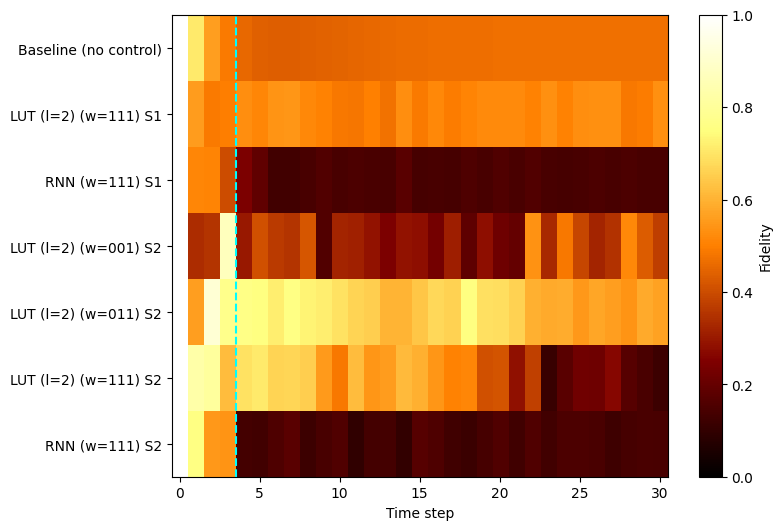

In [ ]:
from matplotlib import pyplot as plt

fig, ax = plt.subplots(figsize=(8,6))
im = ax.imshow(
    fidelities_all,
    aspect="auto",
    cmap="afmhot",
    vmin=0.0, # for better contrast in colormap
    vmax=1.0,
    extent=[0, fidelities_all.shape[1], fidelities_all.shape[0], 0],
    interpolation="none",
)
fig.colorbar(im, ax=ax, label="Fidelity")

ax.set_yticks(np.arange(len(labels))+0.5)
ax.set_yticklabels(labels)
ax.set_xticks(np.arange(0, evaluation_time_steps+1, 5)+0.5)
ax.set_xticklabels(np.arange(0, evaluation_time_steps+1, 5))
ax.set_xlabel("Time step")
ax.axvline(x=4, color="cyan", linestyle="--", label="End of training time")

#fig.savefig("fidelity_heatmap.png", dpi=300, bbox_inches="tight")
#fig.savefig("fidelity_heatmap.pdf", bbox_inches="tight")

In [51]:
fidelities_all[:, 1:15].mean(axis=1)

array([0.47793208, 0.51255649, 0.22748368, 0.35899099, 0.70765965,
       0.64460087, 0.23811789])